In [1]:
import sys
import os
import importlib
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# --- 1. Path Setup ---
# Absolute path to repo root (adjust if necessary)
repo_root = "/files/pixlball"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root) 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_possession_threat_xG_split_final(data_df, match_id: int, possession: int, save_path: str = None):
    """
    Generates a Stacked Area Chart visualization for the Event Head probabilities.
    X-Axis is based on event index/timestamp, and X-Tick labels include player names.

    Args:
        data_df (pd.DataFrame): The full merged dataset containing P_Lose, P_Keep, P_Shot, xG,
                                index, timestamp, and player.
        match_id (int): The match identifier to filter on.
        possession (int): The possession identifier to filter on.
    """
    
    # 1. Filter the Data for the Specific Possession
    sequence_data = data_df[
        (data_df['match_id'] == match_id) & 
        (data_df['possession'] == possession)
    ].copy()
    
    if sequence_data.empty:
        print(f"Error: No data found for Match ID {match_id}, Possession ID {possession}.")
        return

    # --- KEY CHANGE 1: Sort by 'index' (Assumed Chronological Order) ---
    # We sort by the detailed index column and then reset the plotting index
    sequence_data.sort_values(by='index', inplace=True, ignore_index=True)
    sequence_data['seq_index'] = np.arange(len(sequence_data))
    
    # --- 2. Prepare Data and Derive Split Probabilities ---

    # KEY CHANGE 2: Set X-axis values to 'timestamp'
    # We use a numerical representation of the timestamp (like seconds or milliseconds) for plotting positions
    # If 'timestamp' is already a float/int, use it directly. Assuming it's in seconds/milliseconds since start of half.
    # If it's a datetime object, you would need to convert it to total seconds.
    events_x_axis = sequence_data['timestamp'].values
    
    # Base Probabilities
    y_lose = sequence_data['P_Lose'].values
    y_keep = sequence_data['P_Keep'].values
    P_Shot = sequence_data['P_Shot'].values
    xG = sequence_data['xG'].values
    
    # Derive the split probabilities
    y_shot_score = P_Shot * xG
    y_shot_miss = P_Shot * (1 - xG)
    
    # --- 3. Create the Stacked Area Plot ---
    fig, ax = plt.subplots(figsize=(18, 8)) # Increased size for better label visibility

    ax.stackplot(
        events_x_axis, # Use timestamp values for X positions
        y_lose,
        y_keep,
        y_shot_miss, 
        y_shot_score,
        labels=[
            'P(Lose Possession)', 
            'P(Keep Possession)',
            'P(Shot, No Score) [xMiss]', 
            'P(Shot, Score) [xG]'
        ],
        colors=['#ff7f0e', '#1f77b4', '#2ca02c', '#8c564b'],
        alpha=0.8
    )

    # --- 4. Custom X-Axis Labels (Player Names) ---
    
    # KEY CHANGE 3: Create custom labels for the X-axis
    # Format: [Player Name]
    # NOTE: You may need to clean up the player names (e.g., remove full names/initials if they are too long)
    player_labels = sequence_data['player'].values
    
    # Set the tick positions to the timestamp values
    ax.set_xticks(events_x_axis)
    
    # Set the tick labels to the player names
    ax.set_xticklabels(player_labels, rotation=45, ha='right', fontsize=10)


    # --- 5. Add Titles and Style ---
    
    ax.set_xlabel("Event Timestamp (s) and Player Name", fontsize=12)
    ax.set_ylabel("Cumulative Probability / Threat Profile")
    
    ax.set_title(
        f"Possession Chain of Riola Xhemailis Equalizer against Finnland (Match ID: {match_id}, Possession {possession})", 
        fontsize=16
    )
    
    ax.legend(loc='upper right', frameon=True)
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle='--', axis='y', alpha=0.6) # Only grid horizontal lines
    
    plt.tight_layout() # Adjusts plot for rotated labels
    if save_path:
        # We ensure the figure object 'fig' is used for saving
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot successfully saved to: {save_path}")
    else:
        plt.show()



In [3]:
pred_df = pd.read_parquet(os.path.join(repo_root, "notebooks", "baseline_cnn_predictions.parquet"), engine="fastparquet")

In [4]:
data_events = pd.read_parquet(os.path.join(repo_root, "data", "events_data.parquet"), engine="fastparquet")
data_events_keep = data_events[['id', 'index', 'player', 'timestamp', 'shot_outcome', 'type']]

In [5]:
df_merged_left = pd.merge(
    pred_df,
    data_events_keep,
    on='id',
    how='left'  # CRITICAL: This ensures all rows from data_events_keep are preserved.
)

In [6]:
match_id = 3998852
possession = 188

✅ Plot successfully saved to: Threat_Plot_Xhemaili_Equalizer.png


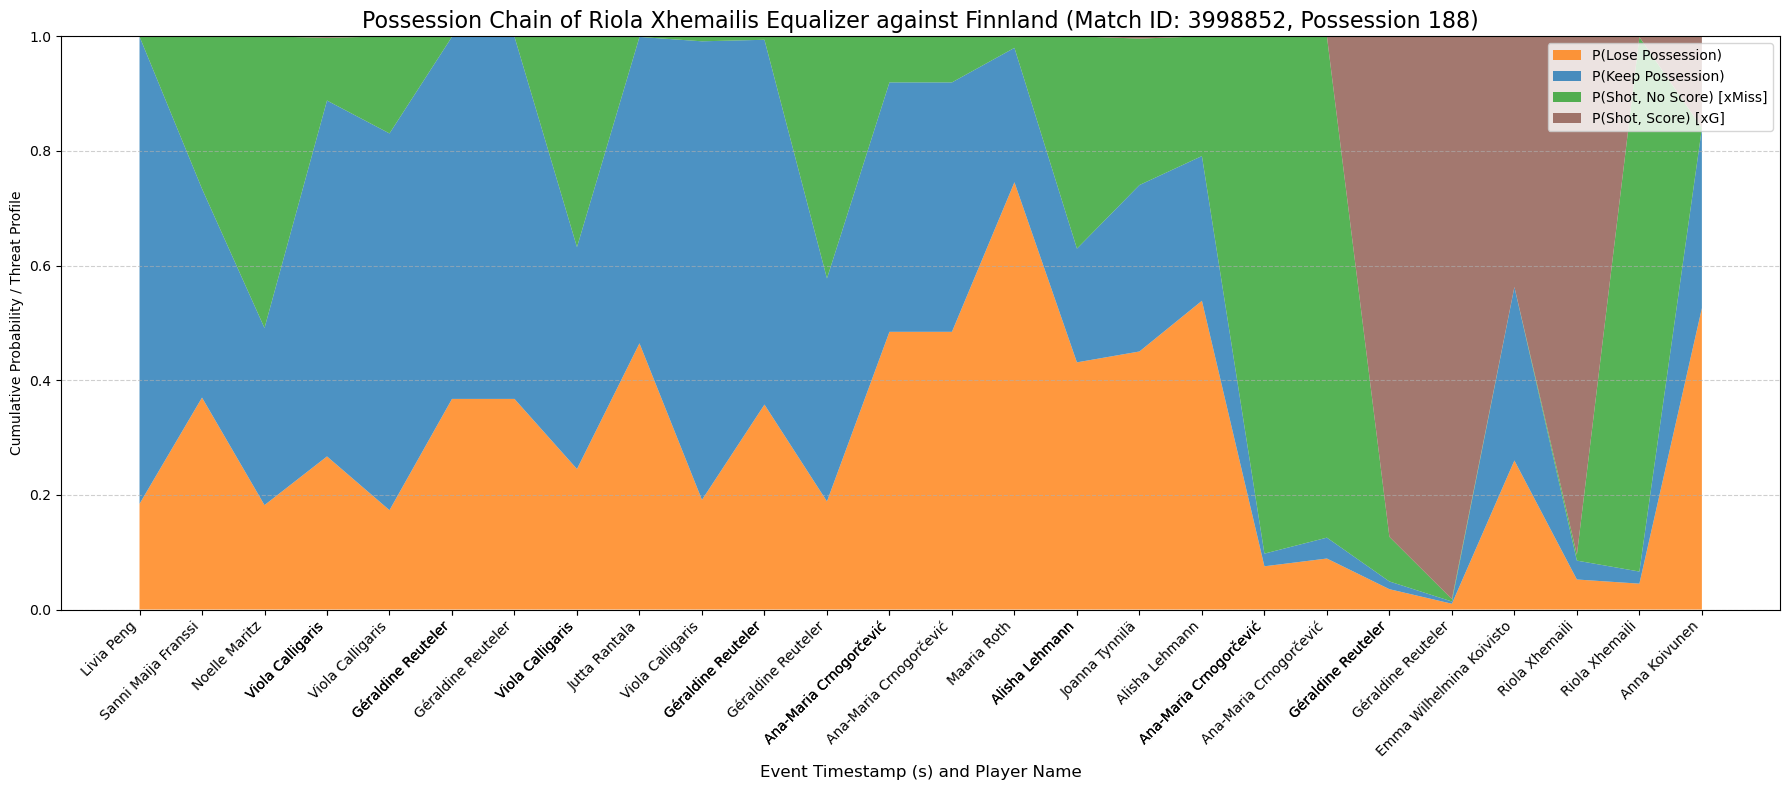

In [7]:
FILENAME = f"Threat_Plot_Xhemaili_Equalizer.png"
plot_possession_threat_xG_split_final(df_merged_left, match_id = match_id, possession = possession, save_path = FILENAME)

In [8]:
 sequence_data = df_merged_left[
        (df_merged_left['match_id'] == match_id) & 
        (df_merged_left['possession'] == possession)
    ].copy()

In [9]:
sequence_data

,id,nn_target,goal_flag,match_id,possession,under_pressure,counterpress,dribble_nutmeg,nn_target_int,P_Lose,P_Keep,P_Shot,xG,index,player,timestamp,shot_outcome,type
44125,07575efb-42ff-47da-9612-6c5a98a6d3d4,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.184385,0.815194,0.000421,2.698082e-03,3597,Livia Peng,00:46:21.072,None,Pass
44126,1815fea4-ac7c-4117-b349-4683ae1ab2e8,Keep Possession,0,3998852,188,0.0,1.0,0.0,0,0.369799,0.364231,0.265970,7.162382e-04,3600,Sanni Maija Franssi,00:46:24.652,None,Pressure
44127,9ff6406b-5249-41f9-9415-f6fa9102d4b9,Keep Possession,0,3998852,188,1.0,0.0,0.0,0,0.182204,0.308996,0.508799,2.466879e-05,3601,Noelle Maritz,00:46:24.726,None,Pass
44128,e75d8a69-f75a-403c-9bf5-97b0d3210123,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.267132,0.620856,0.112012,2.287670e-02,3602,Viola Calligaris,00:46:26.386,None,Ball Receipt*
44129,64a36bf5-2c38-4b79-941e-d75d0a62e383,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.267132,0.620856,0.112012,2.287670e-02,3603,Viola Calligaris,00:46:26.386,None,Carry
44130,982f1fe5-604d-44ff-9fc1-f31749451ebe,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.173368,0.657227,0.169405,1.404430e-05,3604,Viola Calligaris,00:46:27.511,None,Pass
44131,d45b02af-432d-4213-9e29-6d4ac1ad9277,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.367460,0.631807,0.000734,4.919535e-02,3605,Géraldine Reuteler,00:46:28.306,None,Ball Receipt*
44132,5e42fdb9-e6ab-4d4d-b57b-679a6bd9162c,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.367460,0.631807,0.000734,4.919535e-02,3606,Géraldine Reuteler,00:46:28.306,None,Carry
44133,b45f9703-3246-4c1a-b87e-314e740c5d82,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.367460,0.631807,0.000734,4.919535e-02,3607,Géraldine Reuteler,00:46:28.346,None,Pass
44134,8385c441-5eb0-4e97-88f7-36b0aae311a5,Keep Possession,0,3998852,188,0.0,0.0,0.0,0,0.245172,0.387086,0.367741,3.002718e-04,3608,Viola Calligaris,00:46:29.432,None,Ball Receipt*
